In [5]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import json
import seaborn as sbrn
import urllib2
import re
import pickle
from sklearn.cluster import k_means
%matplotlib inline

## Preparing SUSB 2007 for merge into whd_whisard:

This one's at the national level

(data definitions are [here](http://www.census.gov/econ/susb/definitions.html)):
+ For each NAICS, aggregate  
  + num of estalishments (A single physical location where business is conducted or where services or industrial operations are performed)  
  + num employed  
  + payroll  
  + receipts (Estimated Receipts - Receipts (net of taxes collected from customers or clients) are defined as operating revenue for goods produced or distributed, or for services provided. Receipts excludes local, state, and federal sales and other taxes collected from customers or clients and paid directly to a tax agency.)
    

In [2]:
#decided to use SUSB 2007 datasets as most of these (86%) NAICS codes match up with whd_whisard
#try based on older NAICS codes (whd_whisard codes might be older)
#link = 'http://www2.census.gov/econ/susb/data/2007/us_6digitnaics_empl_2007.xls'
path = './../data/us_6digitnaics_empl_2007.xls'

SUSB2007 = pd.read_excel(path, skiprows=6)
SUSB2007.sample(5)


,CODE,NAICS DESCRIPTION,SIZE,OF FIRMS,ESTABLISHMENTS,EMPLOYMENT,RANGE FLAG,NOISE FLAG,-1000,NOISE FLAG.1,-1000.1,NOISE FLAG.2
1466,238320,Painting and Wall Covering Contractors,9: 500+,13,41,8709,NaN,G,342860,G,652424,G
5529,332112,Nonferrous Forging,1: Total,61,72,8273,NaN,G,481138,G,3496447,G
15131,5416,"Management, Scientific, and Technical Consulti...",4: 10-19,6765,7065,89225,NaN,G,5977490,G,16022577,G
4669,326199,All Other Plastics Product Manufacturing,2: 0-4,1373,1374,2658,NaN,G,123543,G,606289,G
18311,722212,Cafeterias,7: 100-499,101,418,13157,NaN,H,157308,G,527792,G


In [4]:
SUSB2007.columns.rename({'Unnamed: 1':'NAICS_desc',
                        'NUMBER':'num_firms',
                        'NUMBER OF':'num_establishments',
                        'Unnamed: 5':'num_employed'},inplace=True)


In [3]:
SUSB2007.columns.values[0]='NAICS'
SUSB2007.columns.values[1]='NAICS_desc'
SUSB2007.columns.values[3]='num_firms'
SUSB2007.columns.values[4]='num_establishments'
SUSB2007.columns.values[5]='num_employed'
SUSB2007.columns.values[8]='payroll'
SUSB2007.columns.values[10]='receipts'
#trust me on this!

In [4]:
SUSB2007.columns=SUSB2007.columns.str.strip()


In [5]:
agg_cols = ['num_firms','num_establishments','num_employed','payroll','receipts']


In [6]:
#first, have to aggregate SUSB2007 into a single row per NAICS. 
#total all counts and average any derived stats
SUSB2007_grps = SUSB2007.groupby(by='NAICS')[agg_cols].aggregate(sum)


In [7]:
SUSB2007_grps.sample(5)

,num_firms,num_establishments,num_employed,payroll,receipts
NAICS,,,,,
337212,5805,5866,111923,4761129,16633764
115111,1012,1055,8808,327381,2126847
3341,4522,4623,226156,16647687,138861218
313241,337,346,15270,450745,2867033
541350,22907,23245,69056,2790715,7296066


In [19]:
SUSB2007_grps.to_pickle('./../pickles/SUSB2007_nationwide_agg.pkl')

# Aggregating Wage Violations to National Level

*whd_whisard* has violations available down to the address/zipcode level by state. I've also incorporated lat/long values based on zip. Since I have SUSB data at a national level for now, I want to do a first run analysis at the national level. For this, I will aggregate *whd_whisard* up to national level, and I'll focus only on FLSA minimum wage and OT violations (based on Michael Eastwood's suggestion) to start with.  


In [6]:
whd_whisard1 = pd.read_csv('/Users/ash/Downloads/wage theft datasets/whd_whisard.csv', low_memory=False)


In [12]:
whd_whisard1.findings_end_date.sort_values(ascending=False)

53946     2024-04-22
65872     2015-12-29
65638     2015-12-28
65329     2015-12-28
65861     2015-12-23
64437     2015-12-22
65875     2015-12-21
64580     2015-12-20
65739     2015-12-18
65774     2015-12-17
65703     2015-12-16
65823     2015-12-16
63210     2015-12-16
65877     2015-12-15
65878     2015-12-15
65856     2015-12-15
65879     2015-12-15
65846     2015-12-15
65850     2015-12-15
52985     2015-12-15
65796     2015-12-15
65855     2015-12-15
65824     2015-12-14
65871     2015-12-14
65876     2015-12-12
65843     2015-12-11
65300     2015-12-11
65863     2015-12-10
65299     2015-12-10
65868     2015-12-10
             ...    
16010     1994-04-14
190686    1993-09-20
215409    1993-09-15
218073    1993-09-14
183789    1992-12-29
190687    1992-11-15
33697     1992-09-15
171276    1992-09-15
35468     1992-06-15
16008     1992-02-15
190683    1991-10-15
209193    1991-08-15
35467     1991-07-27
190684    1991-04-20
190682    1991-02-15
11970     1991-02-15
172552    199

In [9]:
# pull out flsa minimum wage and ot violations specific columns
flsa_grp = ['flsa','flsa_mw','flsa_ot','flsa_smw14','flsa_smwpw','flsa_smwap',
               'flsa_smwft', 'flsa_smwl','flsa_smwmg','flsa_smwsl']
naics_nodes = ['naic_cd','naics_code_description']
agg_cols = [u'case_violtn_cnt', u'cmp_assd_cnt', u'ee_violtd_cnt', u'bw_atp_amt',
       u'ee_atp_cnt',u'flsa_violtn_cnt',u'flsa_bw_atp_amt',
       u'flsa_ee_atp_cnt', u'flsa_mw_bw_atp_amt', u'flsa_ot_bw_atp_amt',
       u'flsa_15a3_bw_atp_amt', u'flsa_cmp_assd_amt', u'sca_violtn_cnt',
       u'sca_bw_atp_amt', u'sca_ee_atp_cnt', u'mspa_violtn_cnt',
       u'mspa_bw_atp_amt', u'mspa_ee_atp_cnt', u'mspa_cmp_assd_amt',
       u'h1b_violtn_cnt', u'h1b_bw_atp_amt', u'h1b_ee_atp_cnt',
       u'h1b_cmp_assd_amt', u'fmla_violtn_cnt', u'fmla_bw_atp_amt',
       u'fmla_ee_atp_cnt', u'fmla_cmp_assd_amt', u'flsa_cl_violtn_cnt',
       u'flsa_cl_minor_cnt', u'flsa_cl_cmp_assd_amt', u'dbra_cl_violtn_cnt',
       u'dbra_bw_atp_amt', u'dbra_ee_atp_cnt', u'h2a_violtn_cnt',
       u'h2a_bw_atp_amt', u'h2a_ee_atp_cnt', u'h2a_cmp_assd_amt',
       u'flsa_smw14_violtn_cnt', u'flsa_smw14_bw_amt',
       u'flsa_smw14_ee_atp_cnt', u'cwhssa_violtn_cnt', u'cwhssa_bw_amt',
       u'cwhssa_ee_cnt', u'osha_violtn_cnt', u'osha_bw_atp_amt',
       u'osha_ee_atp_cnt', u'osha_cmp_assd_amt', u'eppa_violtn_cnt',
       u'eppa_bw_atp_amt', u'eppa_ee_cnt', u'eppa_cmp_assd_amt',
       u'h1a_violtn_cnt', u'h1a_bw_atp_amt', u'h1a_ee_atp_cnt',
       u'h1a_cmp_assd_amt', u'crew_violtn_cnt', u'crew_bw_atp_amt',
       u'crew_ee_atp_cnt', u'crew_cmp_assd_amt', u'ccpa_violtn_cnt',
       u'ccpa_bw_atp_amt', u'ccpa_ee_atp_cnt', u'flsa_smwpw_violtn_cnt',
       u'flsa_smwpw_bw_atp_amt', u'flsa_smwpw_ee_atp_cnt',
       u'flsa_hmwkr_violtn_cnt', u'flsa_hmwkr_bw_atp_amt',
       u'flsa_hmwkr_ee_atp_cnt', u'flsa_hmwkr_cmp_assd_amt', u'ca_violtn_cnt',
       u'ca_bw_atp_amt', u'ca_ee_atp_cnt', u'pca_violtn_cnt',
       u'pca_bw_atp_amt', u'pca_ee_atp_cnt', u'flsa_smwap_violtn_cnt',
       u'flsa_smwap_bw_atp_amt', u'flsa_smwap_ee_atp_cnt',
       u'flsa_smwft_violtn_cnt', u'flsa_smwft_bw_atp_amt',
       u'flsa_smwft_ee_atp_cnt', u'flsa_smwl_violtn_cnt',
       u'flsa_smwl_bw_atp_amt', u'flsa_smwl_ee_atp_cnt',
       u'flsa_smwmg_violtn_cnt', u'flsa_smwmg_bw_atp_amt',
       u'flsa_smwmg_ee_atp_cnt', u'flsa_smwsl_violtn_cnt',
       u'flsa_smwsl_bw_atp_amt', u'flsa_smwsl_ee_atp_cnt', u'eev_violtn_cnt',
       u'h2b_violtn_cnt', u'h2b_bw_atp_amt', u'h2b_ee_atp_cnt',
       u'sraw_violtn_cnt', u'sraw_bw_atp_amt', u'sraw_ee_atp_cnt', u'isMissing_flsa_repeat_violator',
       u'flsa_repeat_violator_R', u'flsa_repeat_violator_RW',
       u'flsa_repeat_violator_W']

In [10]:
#flsa repeat violator, most values are missing, but this could be a good metric. Imputing doesn't make sense. 
#let's dummy the R,RW, and W, and adjust for missing flsa values with a binary
whd_whisard['isMissing_flsa_repeat_violator'] = np.where(whd_whisard['flsa_repeat_violator'].isnull(), 1, 0)
whd_whisard['flsa_repeat_violator_R'] = np.where(whd_whisard['flsa_repeat_violator']=='R', 1, 0)
whd_whisard['flsa_repeat_violator_RW'] = np.where(whd_whisard['flsa_repeat_violator']=='RW', 1, 0)
whd_whisard['flsa_repeat_violator_W'] = np.where(whd_whisard['flsa_repeat_violator']=='W', 1, 0)

In [12]:
ntnl_naics_mdn_vltns = whd_whisard.groupby(by=naics_nodes)[agg_cols].median()

In [14]:
ntnl_sizes = pd.DataFrame(whd_whisard.groupby(by=naics_nodes).size())
ntnl_sizes.columns = ["total_observations"]

In [15]:
ntnl_naics_mdn_vltns = pd.merge(ntnl_naics_mdn_vltns, 
                                ntnl_sizes, 
                                left_index=True, right_index=True)

In [501]:
# also add to this the total number of observations for each NAICS.
# ntnl_naics_mdn_vltns = pd.concat([ntnl_naics_mdn_vltns, whd_whisard.groupby(by=nat_nodes).size()], axis=1, ignore_index=True)


In [230]:
ntnl_naics_mdn_vltns.sample(5)


,,case_violtn_cnt,cmp_assd_cnt,ee_violtd_cnt,bw_atp_amt,ee_atp_cnt,flsa_violtn_cnt,flsa_bw_atp_amt,flsa_ee_atp_cnt,flsa_mw_bw_atp_amt,flsa_ot_bw_atp_amt,...,h2b_bw_atp_amt,h2b_ee_atp_cnt,sraw_violtn_cnt,sraw_bw_atp_amt,sraw_ee_atp_cnt,isMissing_flsa_repeat_violator,flsa_repeat_violator_R,flsa_repeat_violator_RW,flsa_repeat_violator_W,total_observations
naic_cd,naics_code_description,,,,,,,,,,,,,,,,,,,,,
45322,"Gift, Novelty, and Souvenir Stores",2.0,0.0,1.0,0.00,0.0,2.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,57
311111,Dog and Cat Food Manufacturing,0.5,0.0,1.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10
333131,Mining Machinery and Equipment Manufacturing,1.0,0.0,0.0,0.00,0.0,1.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
711219,Other Spectator Sports,2.0,0.0,0.5,0.00,0.0,1.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14
9221,"Justice, Public Order, and Safety Activities",7.0,0.0,7.0,4549.06,7.0,7.0,4549.06,7.0,0.0,4549.06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9


In [20]:
ntnl_naics_mdn_vltns.to_pickle('./../pickles/ntnl_naics_mdn_vltns.pkl')

We now have the average (median) statistics for each violation type at a national level. Next steps are:  
- Pull out FLSA related stats only
- Merge SUSB dataset to get access to nationwide numbers
- Group FLSA stats into FLSA feature
- Engineer "index" features for FLSA Violation Severity, Proportion of Employees Affected, and UnderReported Score

In [298]:
#ntnl_naics_mdn_vltns.drop(ntnl_naics_mdn_vltns.iloc[:,len(ntnl_naics_mdn_vltns.columns)-2], axis=1, inplace=True)

In [21]:
mask = (ntnl_naics_mdn_vltns.columns.str.startswith("flsa")) | (ntnl_naics_mdn_vltns.columns == "total_observations")
all_flsa_cols = ntnl_naics_mdn_vltns.columns[mask]

In [507]:
all_flsa_cols

Index([        u'flsa_violtn_cnt',         u'flsa_bw_atp_amt',
               u'flsa_ee_atp_cnt',      u'flsa_mw_bw_atp_amt',
            u'flsa_ot_bw_atp_amt',    u'flsa_15a3_bw_atp_amt',
             u'flsa_cmp_assd_amt',      u'flsa_cl_violtn_cnt',
             u'flsa_cl_minor_cnt',    u'flsa_cl_cmp_assd_amt',
         u'flsa_smw14_violtn_cnt',       u'flsa_smw14_bw_amt',
         u'flsa_smw14_ee_atp_cnt',   u'flsa_smwpw_violtn_cnt',
         u'flsa_smwpw_bw_atp_amt',   u'flsa_smwpw_ee_atp_cnt',
         u'flsa_hmwkr_violtn_cnt',   u'flsa_hmwkr_bw_atp_amt',
         u'flsa_hmwkr_ee_atp_cnt', u'flsa_hmwkr_cmp_assd_amt',
         u'flsa_smwap_violtn_cnt',   u'flsa_smwap_bw_atp_amt',
         u'flsa_smwap_ee_atp_cnt',   u'flsa_smwft_violtn_cnt',
         u'flsa_smwft_bw_atp_amt',   u'flsa_smwft_ee_atp_cnt',
          u'flsa_smwl_violtn_cnt',    u'flsa_smwl_bw_atp_amt',
          u'flsa_smwl_ee_atp_cnt',   u'flsa_smwmg_violtn_cnt',
         u'flsa_smwmg_bw_atp_amt',   u'flsa_smwmg_ee_at

In [22]:
#[re.sub(r'\'','"',str(val)) for val in all_flsa_cols]
ntnl_naics_mdn_vltns.columns[101]

'total_observations'

In [23]:
ntnl_flsa_mdn_vltns=ntnl_naics_mdn_vltns[all_flsa_cols]

In [24]:
#keep only 'flsa','flsa_mw','flsa_ot','flsa_smw14','flsa_smwpw','flsa_smwap','flsa_smwft', 'flsa_smwl','flsa_smwmg','flsa_smwsl']
#these are MW or OT

flsa2exclude = ['flsa_cl_violtn_cnt','flsa_cl_minor_cnt','flsa_cl_cmp_assd_amt',
               'flsa_hmwkr_violtn_cnt','flsa_hmwkr_bw_atp_amt','flsa_hmwkr_ee_atp_cnt','flsa_hmwkr_cmp_assd_amt']


flsa2include = set(ntnl_flsa_mdn_vltns.columns)-set(flsa2exclude)


In [25]:
flsa2include=list(flsa2include)

In [26]:
ntnl_flsa_mdn_vltns=ntnl_flsa_mdn_vltns[flsa2include]

In [27]:
ntnl_flsa_mdn_vltns.head()

,,flsa_smw14_bw_amt,flsa_smwsl_bw_atp_amt,flsa_smwsl_violtn_cnt,flsa_smwpw_violtn_cnt,flsa_15a3_bw_atp_amt,flsa_smwft_ee_atp_cnt,flsa_ee_atp_cnt,total_observations,flsa_smwl_violtn_cnt,flsa_smwpw_ee_atp_cnt,...,flsa_smwsl_ee_atp_cnt,flsa_smwap_ee_atp_cnt,flsa_smwpw_bw_atp_amt,flsa_smwap_bw_atp_amt,flsa_smwl_ee_atp_cnt,flsa_mw_bw_atp_amt,flsa_bw_atp_amt,flsa_smwl_bw_atp_amt,flsa_ot_bw_atp_amt,flsa_cmp_assd_amt
naic_cd,naics_code_description,,,,,,,,,,,,,,,,,,,,,
09,State and Local Government,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,4250.65,0.0,4250.650,0.0
0911,State Correctional Institutions,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.000,0.0
09110,State Correctional Institutions,0.0,0.0,0.0,0.0,0.0,0.0,0.0,335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.000,0.0
0912,State Fire Protection,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2435.665,2967.11,0.0,531.445,0.0
09120,State Fire Protection,0.0,0.0,0.0,0.0,0.0,0.0,2.5,32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,2133.42,0.0,125.430,0.0


In [28]:
#now, add up all flsa violations for anything_bw_atp_amt, anything_ee_atp_cnt

bw_atp_cols = ntnl_flsa_mdn_vltns.columns[ntnl_flsa_mdn_vltns.columns.str.endswith('_bw_atp_amt')]
ee_atp_cols = ntnl_flsa_mdn_vltns.columns[ntnl_flsa_mdn_vltns.columns.str.endswith('_ee_atp_cnt')]


In [29]:
ntnl_flsa_mdn_vltns['total_flsa_bw_atp_amt'] = np.sum(ntnl_flsa_mdn_vltns[bw_atp_cols], axis=1)
ntnl_flsa_mdn_vltns['total_flsa_ee_atp_cnt'] = np.sum(ntnl_flsa_mdn_vltns[ee_atp_cols], axis=1)

In [30]:
#now, extract only these 2 cols and total_observations
ntnl_flsa = ntnl_flsa_mdn_vltns[['total_flsa_bw_atp_amt','total_flsa_ee_atp_cnt','total_observations']]


# Industry Level Statistics (SUSB)

I can finally merge the industry level SUSB dataset on NAICS code to my aggregated *ntnl_flsa* dataset. This'll help engineer features and give us an idea of nAICS sectors that have severe minimum wage and OT violations, that might be under-reported, and even help see clusters of sectors that behave in a similar manner.

In [31]:
#merge SUSB 2007 dataset t- ntnl_flsa

ntnl_flsa.reset_index(inplace=True)
ntnl_flsa.set_index(ntnl_flsa['naic_cd'], inplace=True)


In [231]:
ntnl_flsa.sample(5)

,naic_cd,naics_code_description,total_flsa_bw_atp_amt,total_flsa_ee_atp_cnt,total_observations,num_firms,num_establishments,num_employed,payroll,receipts,flsa_severity_idx,flsa_reported_rt,flsa_suscptbl_idx
"(314991, Rope, Cordage, and Twine Mills)",314991,"Rope, Cordage, and Twine Mills",70553.49,51.0,2,514,535,11303,410176,2383578,6.242015,0.176944,35.276745
"(31523, Women's and Girls' Cut and Sew Apparel Manufacturing)",31523,Women's and Girls' Cut and Sew Apparel Manufac...,0.00,0.0,645,5230,5263,109058,4287856,32732741,NaN,5.914284,NaN
"(314992, Tire Cord and Tire Fabric Mills)",314992,Tire Cord and Tire Fabric Mills,0.00,0.0,1,56,68,8274,322545,2330494,NaN,0.120861,NaN
"(3122, Tobacco Manufacturing)",3122,Tobacco Manufacturing,0.00,0.0,3,267,334,42610,2561086,85288300,NaN,0.070406,NaN
"(51821, Data Processing, Hosting, and Related Services)",51821,"Data Processing, Hosting, and Related Services",0.00,0.0,21,29235,45391,885379,58004866,170293181,NaN,0.023719,NaN


In [32]:
SUSB2007_grps.head()

,num_firms,num_establishments,num_employed,payroll,receipts
NAICS,,,,,
--,23541021,27423244,322845690,13007823333,74848673978
11,90255,91964,562904,18073145,93840695
113,40632,41070,230350,7784342,40814231
1131,1572,1668,7804,358394,2173256
11311,1572,1668,7804,358394,2173256


In [33]:
ntnl_flsa.shape, SUSB2007_grps.shape

((2259, 5), (2148, 5))

In [34]:
ntnl_flsa=ntnl_flsa.merge(SUSB2007_grps, how='inner', left_index=True, right_index=True)

# New Features

The *FLSA Severity Index* captures the severity of FLSA violations by considering the amount owed per affected employee and multiplying the ratio of affected employees to total employees in the NAICS industry:  

$FLSA Severity Index = (Median FLSA Violation Amount/Affected Employee) * (Affected Employees / Total Employees in NAICS Ind)$  

The *FLSA Reported Rate* captures the number of reported FLSA cases per employee in the NAICS industry: 

$FLSA Reported Rate (per 1000 employees) = (Total FLSA Violation Observations for NAICS Ind) *1000 / (Total Employees in NAICS Ind)$  

Finally, the *FLSA Susceptibility Index* measures the susceptibility of NAICS industries based on the Severity Index and the Reported Rate. This helps surface industries with severe violations but not as many reported cases.  

$FLSA Susceptibility Index = (FLSA Severity Index) / (FLSA Reported Rate)$


In [84]:
#probably lost 14% of NAICS codes in the above merge.
ntnl_flsa['flsa_severity_idx'] = (ntnl_flsa['total_flsa_bw_atp_amt']/ntnl_flsa['total_flsa_ee_atp_cnt']) * (ntnl_flsa['total_flsa_ee_atp_cnt']/ntnl_flsa['num_employed'])
ntnl_flsa['flsa_reported_rt'] = ntnl_flsa['total_observations']*1000/ntnl_flsa['num_employed']
ntnl_flsa['flsa_suscptbl_idx'] = ntnl_flsa['flsa_severity_idx'] / ntnl_flsa['flsa_reported_rt']

**To-do ^^**: Recalculate total_observations to only count FLSA violations

In [85]:
ntnl_flsa.sample(5)

,naic_cd,naics_code_description,total_flsa_bw_atp_amt,total_flsa_ee_atp_cnt,total_observations,num_firms,num_establishments,num_employed,payroll,receipts,flsa_severity_idx,flsa_reported_rt,flsa_suscptbl_idx
"(48819, Other Support Activities for Air Transportation)",48819,Other Support Activities for Air Transportation,0.000,0.0,26,11888,13185,226852,10249657,35652953,NaN,0.114612,NaN
"(561730, Landscaping Services)",561730,Landscaping Services,0.000,0.0,2029,361396,365060,1893366,58928187,184477658,NaN,1.071636,NaN
"(33392, Material Handling Equipment Manufacturing)",33392,Material Handling Equipment Manufacturing,322.000,0.5,6,5468,5776,212698,10395074,63198414,0.001514,0.028209,0.053667
"(42392, Toy and Hobby Goods and Supplies Merchant Wholesalers)",42392,Toy and Hobby Goods and Supplies Merchant Whol...,4184.760,2.0,5,8786,9237,95766,4683566,63534131,0.043698,0.052211,0.836952
"(335921, Fiber Optic Cable Manufacturing)",335921,Fiber Optic Cable Manufacturing,897.105,2.0,22,329,343,13911,765179,4585515,0.064489,1.581482,0.040778


In [79]:
ntnl_flsa.to_pickle('./../pickles/ntnl_flsa_summary.pkl')


# potential plots  
- top flsa (minimum wage/OT) violators nationwide  
- most frequent reports of flsa violations nationwide  
- most susceptible industries to flsa violations nationwide  
- clusters of industries that exhibit similar flsa violations, reporting patterns, and susceptibility

In [67]:
ntnl_flsa.reset_index()
ntnl_flsa.index=ntnl_flsa[['naic_cd','naics_code_description']]


In [167]:
ntnl_flsa.to_csv('./../data/ntnl_flsa_summary.csv')

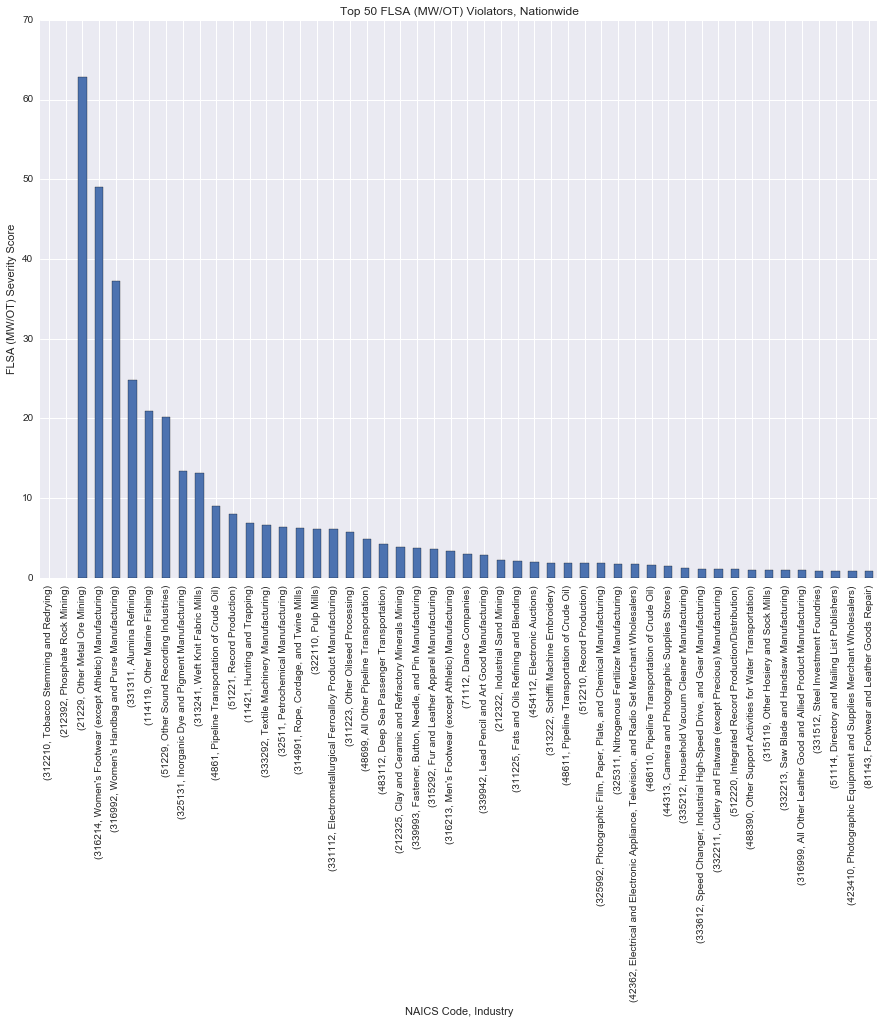

In [80]:
#top flsa (MW/OT) violators nationwide 
ntnl_flsa['flsa_severity_idx'].sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15,10))
plt.ylabel('FLSA (MW/OT) Severity Score')
plt.xlabel('NAICS Code, Industry')
plt.title('Top 50 FLSA (MW/OT) Violators, Nationwide')

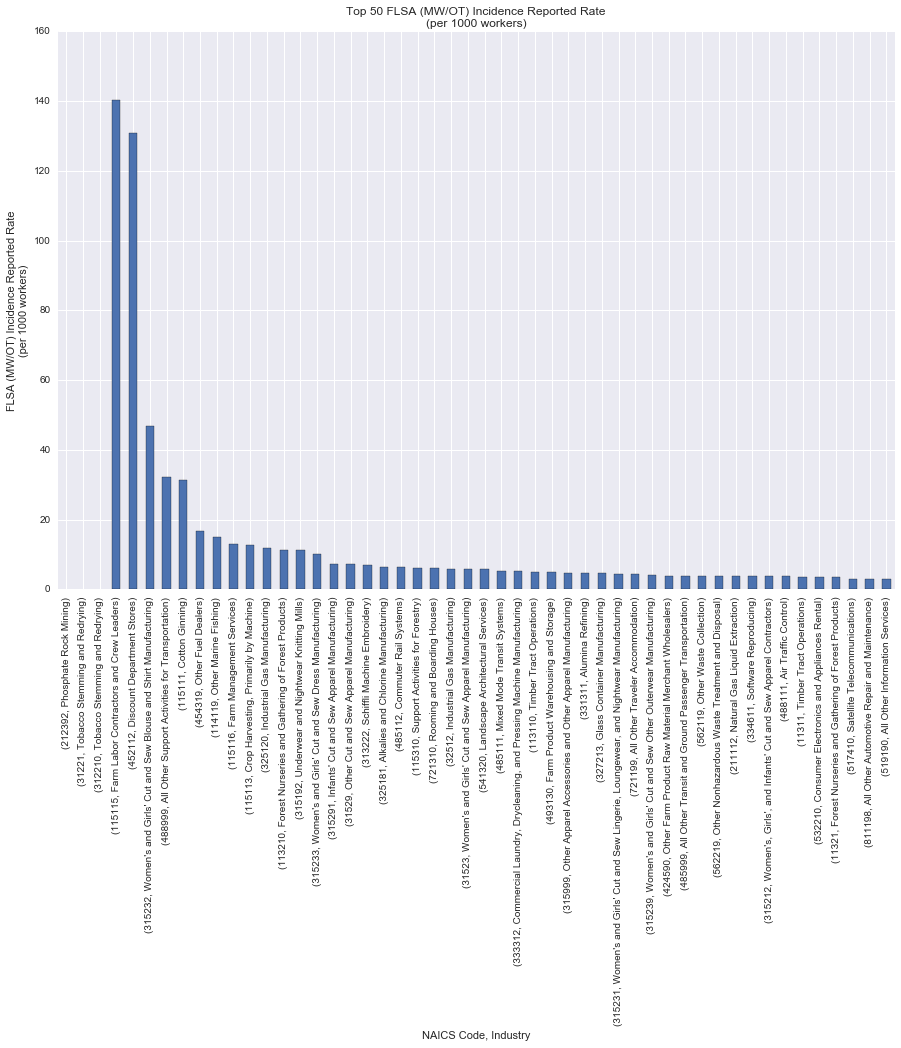

In [83]:
#Most frequent reports of violations

ntnl_flsa['flsa_reported_rt'].sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15,10))
plt.ylabel('FLSA (MW/OT) Incidence Reported Rate\n(per 1000 workers)')
plt.xlabel('NAICS Code, Industry')
plt.title('Top 50 FLSA (MW/OT) Incidence Reported Rate\n(per 1000 workers)')

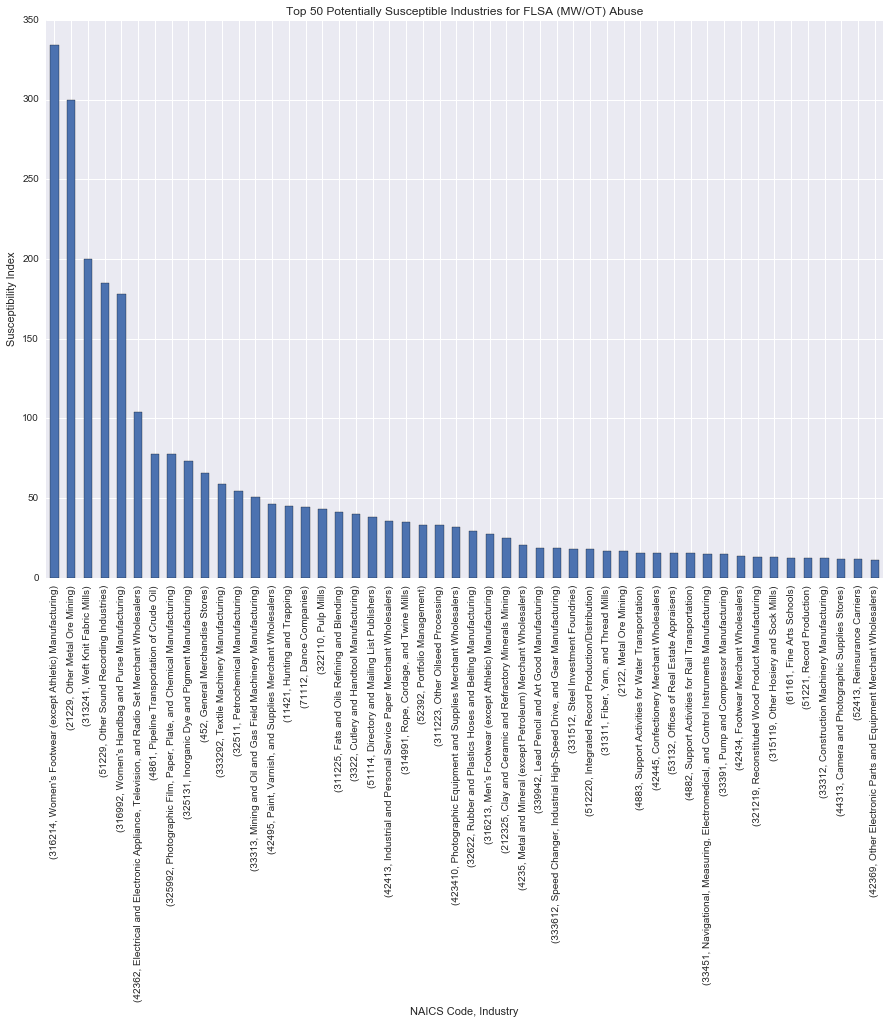

In [86]:
#most susceptible industries (top 50)

ntnl_flsa['flsa_suscptbl_idx'].sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15,10))
plt.ylabel('Susceptibility Index')
plt.xlabel('NAICS Code, Industry')
plt.title('Top 50 Potentially Susceptible Industries for FLSA (MW/OT) Abuse')

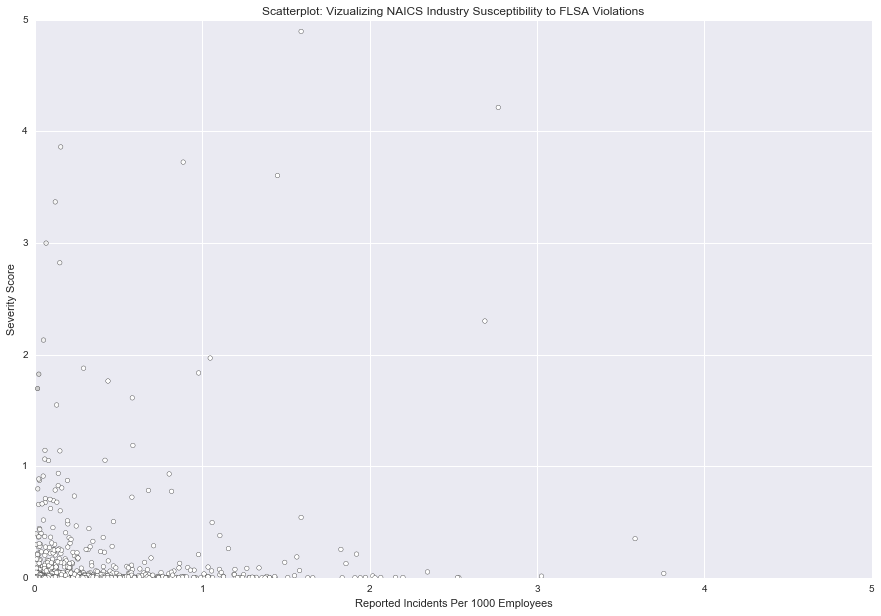

In [99]:
# view a scatter plot of Severity Score Vs. Incidence Reported Rate
plt.figure(figsize=(15,10))
plt.scatter(x='flsa_reported_rt', y='flsa_severity_idx', 
            c='flsa_suscptbl_idx',
           data=ntnl_flsa)
plt.ylim(0,5)
plt.xlim(0,5)
plt.ylabel('Severity Score')
plt.xlabel('Reported Incidents Per 1000 Employees')
plt.title('Scatterplot: Vizualizing NAICS Industry Susceptibility to FLSA Violations')

Going to now try to find clusters of NAICS industries that are similar in severity and reported rate of violations

In [98]:
flsa

,naic_cd,naics_code_description,total_flsa_bw_atp_amt,total_flsa_ee_atp_cnt,total_observations,num_firms,num_establishments,num_employed,payroll,receipts,flsa_severity_idx,flsa_reported_rt,flsa_suscptbl_idx
"(42342, Office Equipment Merchant Wholesalers)",42342,Office Equipment Merchant Wholesalers,36.22,0.5,8,11789,20641,352615,17361483,88571221,0.000103,0.022688,0.004528
"(445230, Fruit and Vegetable Markets)",445230,Fruit and Vegetable Markets,983.38,1.0,81,12460,12871,78394,1622589,15426271,0.012544,1.033242,0.012140
"(31519, Other Apparel Knitting Mills)",31519,Other Apparel Knitting Mills,0.00,0.0,9,854,875,19188,515952,3145588,NaN,0.469043,NaN
"(562991, Septic Tank and Related Services)",562991,Septic Tank and Related Services,1397.04,2.0,48,13093,13333,77396,2808128,9354997,0.018051,0.620187,0.029105
"(52212, Savings Institutions)",52212,Savings Institutions,0.00,0.0,3,3990,37790,572982,28236689,219345693,NaN,0.005236,NaN


In [107]:
cluster_cols = ['flsa_severity_idx','flsa_reported_rt']


In [113]:
ntnl_flsa_nona = ntnl_flsa.dropna()


In [149]:
ntnl_flsa_nona[cluster_cols[0]].head()

(1141, Fishing)                    0.673689
(114112, Shellfish Fishing)        0.378585
(114119, Other Marine Fishing)    20.882818
(11421, Hunting and Trapping)      6.944213
(115111, Cotton Ginning)           0.006698
Name: flsa_severity_idx, dtype: float64

In [118]:
km = k_means(ntnl_flsa_nona[cluster_cols], n_clusters=4, n_init=10, max_iter=1000, verbose=False, n_jobs=-1)


In [138]:
km[0][:4]


array([[  1.69357808e-01,   3.05741449e-01],
       [  4.97016602e+01,   1.88389546e-01],
       [  1.84785458e+01,   4.03188161e+00],
       [  6.69845595e-03,   3.14486830e+01]])

In [140]:
from scipy import cluster

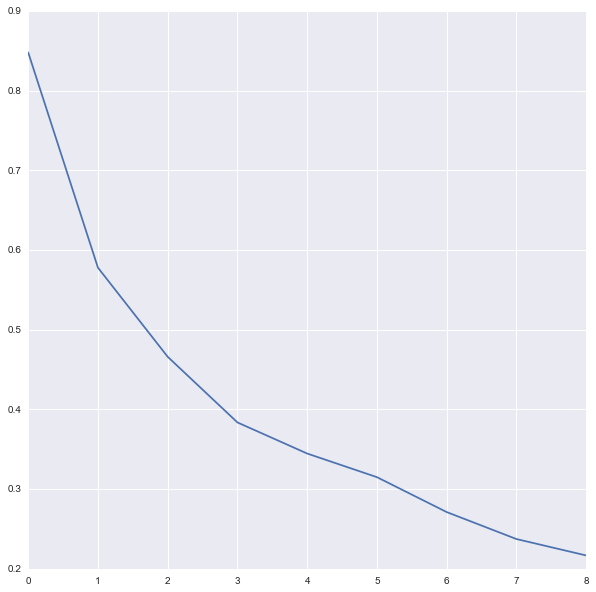

In [145]:
plt.figure(figsize=(10,10))
initial = [cluster.vq.kmeans(ntnl_flsa_nona[cluster_cols],i) for i in range(1,10)]
plt.plot([var for (cent,var) in initial])
#plt.show()

(0, 10)

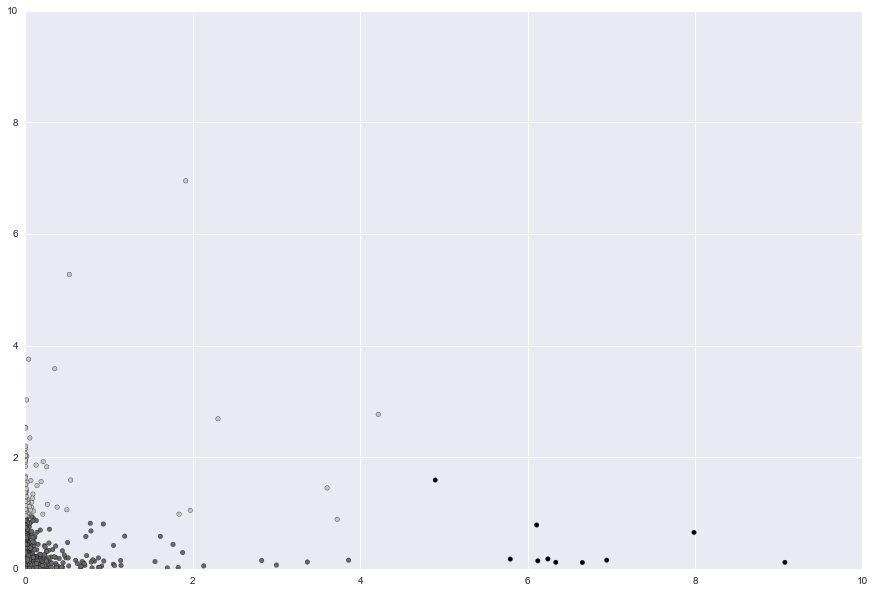

In [163]:
plt.figure(figsize=(15,10))
cent, var = initial[3]
#use vq() to get as assignment for each obs.
assignment,cdist = cluster.vq.vq(ntnl_flsa_nona[cluster_cols],cent)
plt.scatter(ntnl_flsa_nona[cluster_cols[0]], ntnl_flsa_nona[cluster_cols[1]], facecolor='red', c=assignment)
#pyplot.show()



# view a scatter plot of Severity Score Vs. Incidence Reported Rate

#plt.scatter(x='flsa_reported_rt', y='flsa_severity_idx', 
#            c='flsa_suscptbl_idx',
#           data=ntnl_flsa_nona)
plt.ylim(0,10)
plt.xlim(0,10)
#plt.ylabel('Severity Score')
#plt.xlabel('Reported Incidents Per 1000 Employees')
#plt.title('Scatterplot: Vizualizing NAICS Industry Susceptibility to FLSA Violations')

#plt.scatter(km[0], marker='x')


In [188]:
clusters=pd.DataFrame(assignment, columns=['cluster_assignment'])


In [189]:
clusters.head()

,cluster_assignment
0,2
1,1
2,3
3,3
4,1


In [ ]:
ntnl_flsa_nona.reset_index(inplace=True)

In [1]:
ntnl_flsa_nona.sample(5)

NameError: name 'ntnl_flsa_nona' is not defined

In [194]:
ntnl_flsa_clusters=ntnl_flsa_nona.merge(clusters, how='inner', left_index=True, right_index=True)


In [208]:
ntnl_flsa_clusters.index=ntnl_flsa_clusters[['naic_cd','naics_code_description']]


In [210]:
#cluster_labels = {1: 3, 2: 3, 3: 4, 4: 2, 5: 1, 91: 6}
#df['ethnicity'][df.year==year] = df['ethnicity'][df.year==year].map(oldNewMap)

ntnl_flsa_clusters.to_csv('./../data/ntnl_flsa_clusters.csv')


In [2]:
#DBSCAN
from sklearn.cluster import DBSCAN

In [3]:
dbscan=DBSCAN(0.9, min_samples=5, metric='precomputed')

In [ ]:
dbscan.fit(sq_dis)

In [59]:
#whd_whisard.merge(SUSB2007_grps, how='left',left_on='naic_cd',right_index=True)
#whd_whisard[whd_whisard['st_cd']=='CA'].groupby('naic_cd')['case_violtn_cnt'].aggregate(sum)


#new feature: findings_days_taken
whd_whisard['findings_time_taken']=(pd.to_datetime(whd_whisard['findings_end_date'], errors='coerce')-pd.to_datetime(whd_whisard['findings_start_date'], errors='coerce'))


In [68]:
whd_whisard['findings_time_taken']=whd_whisard['findings_time_taken'].astype('timedelta64[D]')


In [91]:
#flsa repeat violator, most values are missing, but this could be a good metric. Imputing doesn't make sense. 
#let's dummy the R,RW, and W, and adjust for missing flsa values with a binary
whd_whisard['isMissing_flsa_repeat_violator'] = np.where(whd_whisard['flsa_repeat_violator'].isnull(), 1, 0)


whd_whisard['flsa_repeat_violator_R'] = np.where(whd_whisard['flsa_repeat_violator']=='R', 1, 0)
whd_whisard['flsa_repeat_violator_RW'] = np.where(whd_whisard['flsa_repeat_violator']=='RW', 1, 0)
whd_whisard['flsa_repeat_violator_W'] = np.where(whd_whisard['flsa_repeat_violator']=='W', 1, 0)

# Part 1: Analysis at National Level
We're going to disregard states and aggregate all NAICS stats to a national level. This way we can combine with the SUSB national level data and get a gauage of industry similarity/clusters at a purely national level. Subsequent analyses may look at differences at the state level, or at more granular nodes.

In [99]:
nat_nodes = ['naic_cd','naics_code_description']
agg_cols = [u'case_violtn_cnt', u'cmp_assd_cnt', u'ee_violtd_cnt', u'bw_atp_amt',
       u'ee_atp_cnt',u'flsa_violtn_cnt',u'flsa_bw_atp_amt',
       u'flsa_ee_atp_cnt', u'flsa_mw_bw_atp_amt', u'flsa_ot_bw_atp_amt',
       u'flsa_15a3_bw_atp_amt', u'flsa_cmp_assd_amt', u'sca_violtn_cnt',
       u'sca_bw_atp_amt', u'sca_ee_atp_cnt', u'mspa_violtn_cnt',
       u'mspa_bw_atp_amt', u'mspa_ee_atp_cnt', u'mspa_cmp_assd_amt',
       u'h1b_violtn_cnt', u'h1b_bw_atp_amt', u'h1b_ee_atp_cnt',
       u'h1b_cmp_assd_amt', u'fmla_violtn_cnt', u'fmla_bw_atp_amt',
       u'fmla_ee_atp_cnt', u'fmla_cmp_assd_amt', u'flsa_cl_violtn_cnt',
       u'flsa_cl_minor_cnt', u'flsa_cl_cmp_assd_amt', u'dbra_cl_violtn_cnt',
       u'dbra_bw_atp_amt', u'dbra_ee_atp_cnt', u'h2a_violtn_cnt',
       u'h2a_bw_atp_amt', u'h2a_ee_atp_cnt', u'h2a_cmp_assd_amt',
       u'flsa_smw14_violtn_cnt', u'flsa_smw14_bw_amt',
       u'flsa_smw14_ee_atp_cnt', u'cwhssa_violtn_cnt', u'cwhssa_bw_amt',
       u'cwhssa_ee_cnt', u'osha_violtn_cnt', u'osha_bw_atp_amt',
       u'osha_ee_atp_cnt', u'osha_cmp_assd_amt', u'eppa_violtn_cnt',
       u'eppa_bw_atp_amt', u'eppa_ee_cnt', u'eppa_cmp_assd_amt',
       u'h1a_violtn_cnt', u'h1a_bw_atp_amt', u'h1a_ee_atp_cnt',
       u'h1a_cmp_assd_amt', u'crew_violtn_cnt', u'crew_bw_atp_amt',
       u'crew_ee_atp_cnt', u'crew_cmp_assd_amt', u'ccpa_violtn_cnt',
       u'ccpa_bw_atp_amt', u'ccpa_ee_atp_cnt', u'flsa_smwpw_violtn_cnt',
       u'flsa_smwpw_bw_atp_amt', u'flsa_smwpw_ee_atp_cnt',
       u'flsa_hmwkr_violtn_cnt', u'flsa_hmwkr_bw_atp_amt',
       u'flsa_hmwkr_ee_atp_cnt', u'flsa_hmwkr_cmp_assd_amt', u'ca_violtn_cnt',
       u'ca_bw_atp_amt', u'ca_ee_atp_cnt', u'pca_violtn_cnt',
       u'pca_bw_atp_amt', u'pca_ee_atp_cnt', u'flsa_smwap_violtn_cnt',
       u'flsa_smwap_bw_atp_amt', u'flsa_smwap_ee_atp_cnt',
       u'flsa_smwft_violtn_cnt', u'flsa_smwft_bw_atp_amt',
       u'flsa_smwft_ee_atp_cnt', u'flsa_smwl_violtn_cnt',
       u'flsa_smwl_bw_atp_amt', u'flsa_smwl_ee_atp_cnt',
       u'flsa_smwmg_violtn_cnt', u'flsa_smwmg_bw_atp_amt',
       u'flsa_smwmg_ee_atp_cnt', u'flsa_smwsl_violtn_cnt',
       u'flsa_smwsl_bw_atp_amt', u'flsa_smwsl_ee_atp_cnt', u'eev_violtn_cnt',
       u'h2b_violtn_cnt', u'h2b_bw_atp_amt', u'h2b_ee_atp_cnt',
       u'sraw_violtn_cnt', u'sraw_bw_atp_amt', u'sraw_ee_atp_cnt',u'findings_time_taken', u'isMissing_flsa_repeat_violator',
       u'flsa_repeat_violator_R', u'flsa_repeat_violator_RW',
       u'flsa_repeat_violator_W']

In [102]:
#pd.options.display.max_seq_items = 115
ntnl_naics_vltns = whd_whisard.groupby(by=nat_nodes)[agg_cols].aggregate(sum)


In [120]:
ntnl_naics_vltns = pd.concat([ntnl_naics_vltns, whd_whisard.groupby(by=nat_nodes).size()], axis=1, ignore_index=False)


,,case_violtn_cnt,cmp_assd_cnt,ee_violtd_cnt,bw_atp_amt,ee_atp_cnt,flsa_violtn_cnt,flsa_bw_atp_amt,flsa_ee_atp_cnt,flsa_mw_bw_atp_amt,flsa_ot_bw_atp_amt,flsa_15a3_bw_atp_amt,flsa_cmp_assd_amt,sca_violtn_cnt,sca_bw_atp_amt,sca_ee_atp_cnt,mspa_violtn_cnt,mspa_bw_atp_amt,mspa_ee_atp_cnt,mspa_cmp_assd_amt,h1b_violtn_cnt,h1b_bw_atp_amt,h1b_ee_atp_cnt,h1b_cmp_assd_amt,fmla_violtn_cnt,fmla_bw_atp_amt,...,flsa_smwft_violtn_cnt,flsa_smwft_bw_atp_amt,flsa_smwft_ee_atp_cnt,flsa_smwl_violtn_cnt,flsa_smwl_bw_atp_amt,flsa_smwl_ee_atp_cnt,flsa_smwmg_violtn_cnt,flsa_smwmg_bw_atp_amt,flsa_smwmg_ee_atp_cnt,flsa_smwsl_violtn_cnt,flsa_smwsl_bw_atp_amt,flsa_smwsl_ee_atp_cnt,eev_violtn_cnt,h2b_violtn_cnt,h2b_bw_atp_amt,h2b_ee_atp_cnt,sraw_violtn_cnt,sraw_bw_atp_amt,sraw_ee_atp_cnt,findings_time_taken,isMissing_flsa_repeat_violator,flsa_repeat_violator_R,flsa_repeat_violator_RW,flsa_repeat_violator_W,0
naic_cd,naics_code_description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
09,State and Local Government,9,0.00,9,4250.65,9,9,4250.65,9,0.00,4250.65,0.0,0.00,0,0.00,0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.00,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,731.0,1,0,0,0,1
0911,State Correctional Institutions,1479,220.00,757,8573077.89,745,384,475928.10,380,0.00,475928.10,0.0,220.00,725,7119576.85,351,0,0.0,0,0.0,0,0.00,0,0.0,8,24320.83,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,14785.0,31,1,0,0,32
09110,State Correctional Institutions,99734,167915.00,12046,16709250.03,11548,11947,16526992.07,11527,42416.98,16484575.09,0.0,167915.00,0,0.00,0,0,0.0,0,0.0,0,0.00,0,0.0,87787,182257.96,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,164192.0,319,15,1,0,335
0912,State Fire Protection,13,0.00,13,5934.22,12,13,5934.22,12,4871.33,1062.89,0.0,0.00,0,0.00,0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.00,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,748.0,2,0,0,0,2
09120,State Fire Protection,2221,561.00,235,473312.02,230,238,472634.02,229,101114.58,371519.44,0.0,561.00,0,0.00,0,0,0.0,0,0.0,0,0.00,0,0.0,1983,678.00,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,21775.0,30,2,0,0,32
0913,State Ambulance and Rescue Squads (except fire or police),320,0.00,315,432388.81,315,319,432388.81,315,203.12,432185.69,0.0,0.00,0,0.00,0,0,0.0,0,0.0,0,0.00,0,0.0,1,0.00,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,2732.0,3,0,0,0,3
09130,State Ambulance and Rescue Squads (except fire or police),106,0.00,104,148984.95,104,106,148984.95,104,0.00,148984.95,0.0,0.00,0,0.00,0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.00,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,6091.0,9,0,0,0,9
0914,State Police Protection,387,0.00,384,966075.15,382,385,966075.15,382,18493.59,947581.56,0.0,0.00,0,0.00,0,0,0.0,0,0.0,0,0.00,0,0.0,2,0.00,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,4852.0,8,0,0,0,8
09140,State Police Protection,2594,24640.00,2559,7136468.61,2537,2575,7132665.88,2534,2825.03,7129840.85,0.0,24640.00,0,0.00,0,0,0.0,0,0.0,0,0.00,0,0.0,19,3802.73,...,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,43313.0,61,6,1,0,68


In [137]:
ntnl_naics_vltns.columns.values[102] = 'total_observations'


In [139]:
import pickle


In [172]:
ntnl_naics_vltns.to_pickle('/Users/ash/ds/projects/DOL-wage-theft/pickles/national_naics_dataset.pkl')


In [160]:
ntnl_naics_vltns.reset_index(inplace=True)


In [171]:
#now merge SUSB2007_grps to national dataset
ntnl_naics_vltns=ntnl_naics_vltns.merge(SUSB2007_grps, how='left', left_on='naic_cd', right_index=True)


In [174]:
ntnl_naics_vltns.index = ntnl_naics_vltns.naic_cd


# Gauging Severity of NAICS Violations Nationwide

We need a new metric that, for every NAICS sector, gauges the severity of the industry's violations when compared to the total number employed nationwide in that sector. We can do this by comparing the total employees affected by each violation type to the total employees employed in that sector nationwide. 

We can also do the same thing to get an idea of monetary penalty severity by comparing the total amounts owed for each violation to the total annual payroll for that sector. 

Finally, we can create an overall gauge that combines the two metrics above and normalizes by # of observations. This helps mitigate the effect that NAICS with a high # of observations in this dataset might have, and helps surface the industries with a lower # of *known* cases. 

In [ ]:
# The first metric is the Emp_Afctd_Svrty . For each NAICS row, and for each violation type ("<violation type>_ee_atp_cnt"/"num_employed")

In [182]:
null_aggs = ntnl_naics_vltns[ntnl_naics_vltns['num_firms'].isnull()]

In [183]:
null_aggs.shape

(300, 110)

In [191]:
#okay, we'll just remove these 300 sectors from the analysis for now.
ntnl_naics_vltns = ntnl_naics_vltns[~ntnl_naics_vltns['num_firms'].isnull()]

In [193]:
ntnl_naics_vltns.sample(1)

,naic_cd,naics_code_description,case_violtn_cnt,cmp_assd_cnt,ee_violtd_cnt,bw_atp_amt,ee_atp_cnt,flsa_violtn_cnt,flsa_bw_atp_amt,flsa_ee_atp_cnt,flsa_mw_bw_atp_amt,flsa_ot_bw_atp_amt,flsa_15a3_bw_atp_amt,flsa_cmp_assd_amt,sca_violtn_cnt,sca_bw_atp_amt,sca_ee_atp_cnt,mspa_violtn_cnt,mspa_bw_atp_amt,mspa_ee_atp_cnt,mspa_cmp_assd_amt,h1b_violtn_cnt,h1b_bw_atp_amt,h1b_ee_atp_cnt,h1b_cmp_assd_amt,...,flsa_smwl_ee_atp_cnt,flsa_smwmg_violtn_cnt,flsa_smwmg_bw_atp_amt,flsa_smwmg_ee_atp_cnt,flsa_smwsl_violtn_cnt,flsa_smwsl_bw_atp_amt,flsa_smwsl_ee_atp_cnt,eev_violtn_cnt,h2b_violtn_cnt,h2b_bw_atp_amt,h2b_ee_atp_cnt,sraw_violtn_cnt,sraw_bw_atp_amt,sraw_ee_atp_cnt,findings_time_taken,isMissing_flsa_repeat_violator,flsa_repeat_violator_R,flsa_repeat_violator_RW,flsa_repeat_violator_W,total_observations,num_firms,num_establishments,num_employed,payroll,receipts
naic_cd,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
442110,442110,Furniture Stores,4170,98503.0,3261,1517944.41,3082,3958,1476860.22,3079,337943.6,1138916.62,0.0,79101.0,24,30356.99,24,0,0.0,0,0.0,0,0.0,0,0.0,...,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,193486.0,269,18,0,1,288,78434.0,101520.0,818479.0,24243548.0,170753194.0


In [262]:
#aaight, ready to create new severity quotients by violation
# 28 distinct types of violations present, most of them have bw_atp_amt, ee_atp_amt, and cmp_assd_amt info. 
case_violtn_cnt_per_estab = ntnl_naics_vltns['case_violtn_cnt']/ntnl_naics_vltns['num_establishments']
cmp_assd_cnt_per_estab = ntnl_naics_vltns['cmp_assd_cnt']/ntnl_naics_vltns['num_establishments'] #revisit!
bw_atp_amt_ratio_payroll = ntnl_naics_vltns['bw_atp_amt']/ntnl_naics_vltns['payroll']
ee_violtd_cnt_ratio_employed = ntnl_naics_vltns['ee_violtd_cnt']/ntnl_naics_vltns['num_employed']
    

Types of violations are listed out. There are 31 of them. For each violation, we **mostly** see the following attributes:  
- ...**_violtn_cnt**: # of violations for type  
- ...**_bw_atp_amt**: backwages agreed to pay, dollar amount
- ...**_ee_atp_cnt**: # of employees agreed to pay
- ...**_cmp_assd_amt**:  civil monetary penalties assessed, dollar amount (only for some)

In [260]:
violtn_typs = ['flsa','flsa_mw','flsa_ot','flsa_15a3','flsa_cl','flsa_smw14','flsa_smwpw', 'flsa_hmwkr','flsa_smwap',
               'flsa_smwft', 'flsa_smwl','flsa_smwmg','flsa_smwsl','eev','sca','mspa','h1b','fmla','dbra','h2b',
              'dbra_cl','h2a','cwhssa','osha','eppa','h1a','crew','ccpa','ca','pca','sraw']

Normalize each NAICS violation type based on overall numbers available. 
- ...**_violtn_cnt** / **num_establishments**  
- ...**_bw_atp_amt** / **payroll** (backwages owed for violation type as a chunk of total NAICS payroll)
- ...**_ee_atp_cnt** / **num_employed** (eemployes  (affected) for violation type as chunk of total employees)  
- ...**_cmp_assd_amt** / **payroll** (cmp's amount for violation type as chunk of total NAICS payroll)

Finally, for each violation type, assign a *severity_index*; this normalizes by # of observations for that NAICS to help surface those with lesser reports; also contains a smoothing factor to mitigate excessive penalty caused by large # of observations:  
$[(norm. violations count)*(norm. chunk of affected employees)*(norm. bw owed)*(norm. cmp assessed)] * log(total observations + 1) / total # observations for that NAICS$ 

In [258]:
ntnl_naics_vltns.columns

Index([                       u'naic_cd',         u'naics_code_description',
                      u'case_violtn_cnt',                   u'cmp_assd_cnt',
                        u'ee_violtd_cnt',                     u'bw_atp_amt',
                           u'ee_atp_cnt',                u'flsa_violtn_cnt',
                      u'flsa_bw_atp_amt',                u'flsa_ee_atp_cnt',
                   u'flsa_mw_bw_atp_amt',             u'flsa_ot_bw_atp_amt',
                 u'flsa_15a3_bw_atp_amt',              u'flsa_cmp_assd_amt',
                       u'sca_violtn_cnt',                 u'sca_bw_atp_amt',
                       u'sca_ee_atp_cnt',                u'mspa_violtn_cnt',
                      u'mspa_bw_atp_amt',                u'mspa_ee_atp_cnt',
                    u'mspa_cmp_assd_amt',                 u'h1b_violtn_cnt',
                       u'h1b_bw_atp_amt',                 u'h1b_ee_atp_cnt',
                     u'h1b_cmp_assd_amt',                u'fmla_violtn_cnt',

In [263]:
ntnl_naics_vltns.sample(8)

,naic_cd,naics_code_description,case_violtn_cnt,cmp_assd_cnt,ee_violtd_cnt,bw_atp_amt,ee_atp_cnt,flsa_violtn_cnt,flsa_bw_atp_amt,flsa_ee_atp_cnt,flsa_mw_bw_atp_amt,flsa_ot_bw_atp_amt,flsa_15a3_bw_atp_amt,flsa_cmp_assd_amt,sca_violtn_cnt,sca_bw_atp_amt,sca_ee_atp_cnt,mspa_violtn_cnt,mspa_bw_atp_amt,mspa_ee_atp_cnt,mspa_cmp_assd_amt,h1b_violtn_cnt,h1b_bw_atp_amt,h1b_ee_atp_cnt,h1b_cmp_assd_amt,...,flsa_smwl_ee_atp_cnt,flsa_smwmg_violtn_cnt,flsa_smwmg_bw_atp_amt,flsa_smwmg_ee_atp_cnt,flsa_smwsl_violtn_cnt,flsa_smwsl_bw_atp_amt,flsa_smwsl_ee_atp_cnt,eev_violtn_cnt,h2b_violtn_cnt,h2b_bw_atp_amt,h2b_ee_atp_cnt,sraw_violtn_cnt,sraw_bw_atp_amt,sraw_ee_atp_cnt,findings_time_taken,isMissing_flsa_repeat_violator,flsa_repeat_violator_R,flsa_repeat_violator_RW,flsa_repeat_violator_W,total_observations,num_firms,num_establishments,num_employed,payroll,receipts
naic_cd,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
322213,322213,Setup Paperboard Box Manufacturing,30,0.0,27,26059.59,27,26,2059.59,26,0.00,2059.59,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.00,0,0.0,...,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,2906.0,4,0,0,0,4,290.0,308.0,10201.0,378285.0,1448381.0
44529,44529,Other Specialty Food Stores,403,36259.0,355,336186.68,310,353,336186.68,310,39560.95,296625.73,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.00,0,0.0,...,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,25063.0,43,1,0,0,44,50630.0,60207.0,327086.0,4678639.0,26598427.0
3334,3334,"Ventilation, Heating, Air-Conditioning, and Co...",55,0.0,52,66630.66,51,49,65692.58,46,0.00,65692.58,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.00,0,0.0,...,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,4912.0,7,0,0,0,7,5285.0,5945.0,354286.0,14559847.0,93938073.0
488310,488310,Port and Harbor Operations,304,0.0,304,121682.43,281,303,121682.43,281,0.00,121682.43,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.00,0,0.0,...,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,5822.0,11,0,0,0,11,603.0,706.0,16217.0,770835.0,3589587.0
114119,114119,Other Marine Fishing,37,0.0,33,19162.20,32,37,19162.20,32,36.63,19125.57,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.00,0,0.0,...,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,3280.0,5,0,0,0,5,52.0,52.0,330.0,14358.0,126579.0
561492,561492,Court Reporting and Stenotype Services,67,0.0,51,41755.70,49,56,33575.32,47,0.00,33575.32,0.0,0.0,0,0.0,0,0,0.0,0,0.0,6,3770.01,1,0.0,...,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,7775.0,13,1,0,0,14,12958.0,13346.0,50388.0,1889983.0,7255872.0
332913,332913,Plumbing Fixture Fitting and Trim Manufacturing,79,0.0,62,116419.47,59,28,34266.78,25,0.00,34266.78,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.00,0,0.0,...,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,5435.0,9,0,0,0,9,451.0,484.0,25042.0,1033562.0,9046325.0
71311,71311,Amusement and Theme Parks,271,100408.5,230,474195.57,139,168,474195.57,139,28532.32,445663.25,0.0,14465.0,0,0.0,0,0,0.0,0,0.0,0,0.00,0,0.0,...,0,0,0.0,0,0,0.0,0,0,2,0.0,0,0,0.0,0,15912.0,24,2,0,0,26,2024.0,2208.0,215782.0,5259318.0,26081725.0


In [ ]:
k_means(ntnl_)